          Dataset         Model  Accuracy      AUC  F1-score  Type I Error  Type II Error
    German Credit       XGBoost  0.742000 0.772571  0.527484      0.092199       0.457627
    German Credit Decision Tree  0.686000 0.615476  0.464491      0.248227       0.559322
    German Credit Random Forest  0.753000 0.790321  0.474100      0.056738       0.644068
    German Credit           SVM  0.763000 0.784952  0.493618      0.070922       0.559322
Australian Credit       XGBoost  0.875362 0.927706  0.886974      0.176471       0.114943
Australian Credit Decision Tree  0.814493 0.810035  0.837569      0.196078       0.103448
Australian Credit Random Forest  0.863768 0.930965  0.875516      0.176471       0.091954
Australian Credit           SVM  0.853623 0.912786  0.862179      0.196078       0.126437


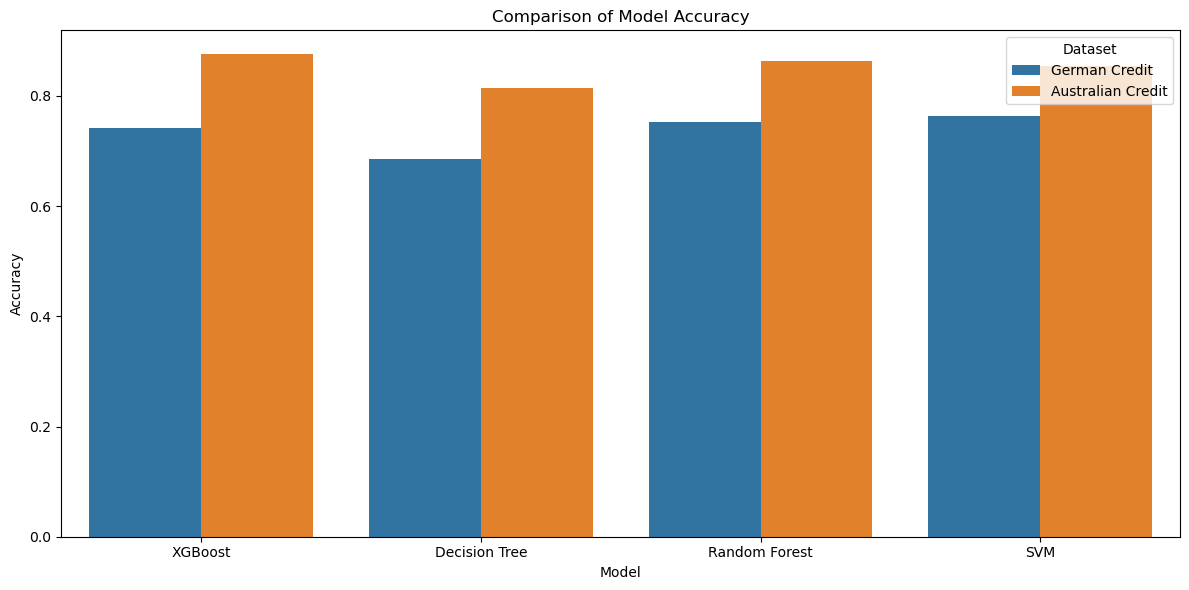


Results saved to 'credit_model_comparison_results.csv'


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def preprocess_data(df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X = pd.get_dummies(X, drop_first=True)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

def evaluate_model(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    accuracy = cv_scores.mean()
    auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()
    f1 = cross_val_score(model, X, y, cv=5, scoring='f1').mean()
    
    # Calculate Type I and Type II errors
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    type1_error = fp / (fp + tn)
    type2_error = fn / (fn + tp)
    
    return accuracy, auc, f1, type1_error, type2_error

def analyze_dataset(df, target_column, dataset_name):
    X, y = preprocess_data(df, target_column)
    
    models = {
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(probability=True)
    }
    
    results = []
    
    for model_name, model in models.items():
        accuracy, auc, f1, type1_error, type2_error = evaluate_model(model, X, y)
        results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'AUC': auc,
            'F1-score': f1,
            'Type I Error': type1_error,
            'Type II Error': type2_error
        })
    
    return pd.DataFrame(results)

# Load datasets
german_df = pd.read_csv('..\Data\data1.csv')
australian_df = pd.read_csv('..\Data\data2.csv')

# Analyze German Credit Dataset
german_results = analyze_dataset(german_df, 'Y(1=default, 0=non-default)', 'German Credit')

# Analyze Australian Credit Dataset
australian_results = analyze_dataset(australian_df, 'Y(1=default, 0=non-default)', 'Australian Credit')

# Combine results
all_results = pd.concat([german_results, australian_results])

# Display results
print(all_results.to_string(index=False))

# 绘制准确率条形图
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=all_results)
plt.title('Comparison of Model Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')

plt.savefig('..\Data\Q3_Accuracy.png')
plt.tight_layout()
plt.show()

# Save results to CSV
all_results.to_csv('..\Data\credit_model_comparison_results.csv', index=False)
print("\nResults saved to 'credit_model_comparison_results.csv'")